# Reacher Arm Project

![Screenshot of reacher arm environment](doc/BannerImage.png)

This is an implementation of the Deep Deterministic Policy Gradients Algorithm for training a two joint arm to keep its end effector within a moving target volume.  The agent actions are four continuous inputs corresponding to the torques on two joints.

## Table of Contents
+ Environment Setup
+ Description of Algorithm
  - N-Step Bootstrapping
  - Prioritized Replay
+ Implementation of Algorithm
  - Hyperparameters
  - Helpers
  - Network Definition
  - Training Code
+ Training
+ Results
+ References

## Environment Setup

+ Follow instructions [here](https://github.com/udacity/Value-based-methods#dependencies) to set up the environment, *with the following changes:*
  - Before running `pip install .`, edit `Value-based-methods/python/requirements.txt` and remove the `torch==0.4.0` line
  - After running `pip install .`, run the appropriate PyTorch installation command for your system indicated [here](https://pytorch.org/get-started/locally/)
  - Continue following the instructions [here](https://github.com/udacity/Value-based-methods#dependencies) to their conclusion.
+ Download the appropriate Unity Environment for your platform:
  - [Linux](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip)
  - [Mac OSX](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher.app.zip)
  - [Windows (32-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Windows_x86.zip)
  - [Windows (64-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Windows_x86_64.zip)
+ Place the Unity Environment zip file into any convenient directory, and unzip the file.

### Imports and references
Run the following code cell at every kernel instance start-up to bring implementation dependencies into the notebook namespace, and identify the path to the simulated environment executable.

In [1]:
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam

# Set to the path to simulated environment executable on system.
env_location = \
    "C:/Projects/UdacityRLp2/Reacher_Windows_x86_64/Reacher_Windows_x86_64/Reacher.exe"

## Description of Algorithm

The Deep Deterministic Policy Gradient (DDPG) algorithm extends the application of Q-Learning methods to action spaces with continuously valued dimensions [[1]](#References).  There are two networks involved, a Policy Network and Action Value (Q) network.  During learning, the Policy Network generates an action according to the input state, and both this action and the state are supplied to the Q network as input.  The Q network outputs a single action value, and the gradient of this value with respect to the parameters of the Policy Network are used to nudge the policy towards one with a higher action value (by gradient ascent). <br><br> 
In typical Deep Q Learning (DQN), each action has a corresponding output from the Q network, but this representation of the Action Value Function $Q(s,a)$ does not naturally accomodate continuously-valued actions.  The primary difference of DDPG with respect to DQN, is that actions are instead explicit, continuously valued inputs to the Action Value function approximation.  This allows closed-form computation of the gradient of $Q(s,a)$ with respect to changes in magnitudes of the continuously-valued action variables.

The basic DDPG algorithm reads as follows (from [[1]](#References)): <br>
![DDPG Algorithm](doc/DDPG_alg.png) <br>

This implementation does not require that the environment steps and learning steps happen at the same time, or in a 1:1 ratio.  It also incorporates the following improvements:

### N-Step Bootstrapping

The hyperparameter `n_step_order`, determines the value of $n$ in the following alternative Bellman Update target, replacing the definition for $y_i$ in the algorithm above:

$$y_i = r_i + \gamma r_{i+1} + \gamma^2 r_{i+2} + ... + \gamma^n r_{i+n} + \gamma^{n+1} Q'(s_{i+n+1},\mu '(s_{i+n+1}|\theta^{\mu '})|\theta^{Q'})$$

N-Step Bootstrapping increases the relative weight of sampled rewards from the environment, compared to rewards estimated by the Action Value function $Q(s,a)$. Anecdotally, this seems to assist action values propagating backwards in time and through 'bottlenecks' where most nearby states have comparatively low State Values.  So essentially, initial learning can be faster, and some connections may be made that would otherwise take an unacceptably long time to be made without N-Step Bootstrapping.  However, real rewards are stochastic, and an atypically bad or good run of events will  more readily propagate through a Q network with N-Step Bootstrapping.  If an agent quickly changes its behavior between simple, regimented approaches, it is possible the `n_step_order` value in use is too high for the agent's environment.

### Prioritized Replay
The algorithm will periodically switch between exploration and learning phases.  <br><br>During exploration phases, state transition tuples $(S_t,a_t,r_t,S_{t+1})$ will be collected, transformed to *n-step* transition events via an accumulation buffer, and stored in a prioritized experience buffer. 
<br><br>
During learning phases, transition events sampled from the prioritized experience buffer will be used to optimize the parameters of the Policy and Q networks.  Like in [[2]](#References), the probability of utilizing a transition $T$ from the experience buffer is consistent with the proportionality relation: <br><br>
$$p_T \varpropto (Loss)^{\alpha}, \alpha \in [0,\infty)$$
<br>
The hyperparameter $\alpha$ allows tuning of the degree to which the probability of selection is affected by loss magnitude [[2]](#References).
<br><br>Qualitatively, the $Loss$ in this context is proportional to how inconsistent the parameterized model's prediction is with a prediction that uses actual rewards sampled from the environment.  See the implementation section for detail on how the loss is computed.

## Implementation of Algorithm

### Hyperparameters

#### Environment
`state_dim`: Dimension of the observable state space<br>
`act_dim`: Dimension of the action space for each agent <br>
`num_agnt`: Number of agents in the environment

#### Network Models
`pol_hid_num`: Number of hidden layers in the Policy Network<br>
`pol_hid_size`: Number of neurons in each hidden layer of the Policy Network<br>
`noise_init`: Initial noise weights for NoisyNet layers<br>
`noise_sigma`: Magnitude of white noise input to Orstein-Uhlenbeck, see [[1]](#References)<br>
`noise_theta`: Decay constant for Orstein-Uhlenbeck, see [[1]](#References)<br>
`q_hid_num`: Number of hidden layers in the Q Network<br>
`q_hid_size`: Number of neurons in each hidden layer of the Q Network<br>

#### Reward Parameters
`gamma`: Discount factor per step for rewards<br>
`n_step_order`: Number of reward steps to directly incorporate into Bellman Update estimate<br>

#### Replay Parameters
`buf_life`: Buffer will be reset every this many samples<br>
`buf_min_size`: Learning will not be allowed unless replay buffer has this many experiences, to avoid overfitting<br>
`alpha`: Prioritization strength factor, see [[2]](#References)<br>
`beta`: Importance sampling correction coefficient, see [[2]](#References)<br>

#### Optimization Parameters
`pol_lr`: Learning rate for Policy Network optimizer<br>
`q_lr`: Learning rate for Q Network optimizer<br>
`lr_int`: Number of environment steps between each learning phase<br>
`lr_stps`: How many learning steps are applied during each learning phase<br>
`batch_size`: How many experiences are processed by each agent for each learning step<br>
`p_tau`: Soft update factor for target Policy Network, applied once every learning step<br>
`q_tau`: Soft update factor for the Q Network, applied once every learning step<br>

#### Training Parameters
`max_eps`: Maximum number of episodes for which to train<br>
`avg_wnd_len`: Length (in episodes) of running average buffer for reported performance<br>
`rprt_int`: Number of episodes between prints of performance<br>
`slv_thresh`: Minimum average score constituting solution of environment, the achievement of which will end the training run

In [2]:
class DDPG_Hyperparameters():
    def __init__(self,
                 state_dim=33,
                 act_dim=4,
                 num_agnt=20,
                 pol_hid_num=1,
                 pol_hid_size=300,
                 noise_init=0.0,
                 noise_decay=0.98,
                 noise_theta=0.01,
                 q_hid_num=1,
                 q_hid_size=300,
                 gamma=0.99,
                 n_step_order=1,
                 buf_life=1e6,
                 buf_min_size=10000,
                 alpha=0.7,
                 beta=1.0,
                 pol_lr=2e-5,
                 q_lr=2e-4,
                 lr_int=10,
                 lr_stps=20,
                 batch_size=32,
                 p_tau=1e-3,
                 q_tau=1e-3,
                 max_eps=2000,
                 avg_wnd_len=100,
                 rprt_int=2,
                 slv_thresh=30):
        self.state_dim, self.act_dim, self.num_agnt = state_dim, act_dim, num_agnt
        self.pol_hid_num, self.pol_hid_size, self.noise_init = pol_hid_num, pol_hid_size, noise_init
        self.q_hid_num, self.q_hid_size, self.gamma = q_hid_num, q_hid_size, gamma
        self.n_step_order, self.buf_life, self.buf_min_size = n_step_order, buf_life, buf_min_size
        self.alpha, self.beta, self.pol_lr = alpha, beta, pol_lr
        self.q_lr, self.lr_int, self.lr_stps = q_lr, lr_int, lr_stps
        self.batch_size, self.p_tau, self.q_tau = batch_size, p_tau, q_tau
        self.max_eps, self.avg_wnd_len, self.rprt_int = max_eps, avg_wnd_len, rprt_int
        self.slv_thresh, self.noise_decay, self.noise_theta = slv_thresh, noise_decay, noise_theta

def_hyp = DDPG_Hyperparameters()

### Helpers

In [3]:
# Debugging function
def tensor_check(input,desc,exp_size):
    if torch.any(torch.isnan(input)):
        print(f'NaNs in {desc}:')
        print(input)
    if torch.any(torch.isinf(input)):
        print(f'Inf in {desc}:')
        print(input)
    if not (input.size() == torch.Size(exp_size)):
        print(f'{desc} has size {tuple(input.size())}, not {exp_size} expected')

# Copied from the Lunar Lander dqn_agent.py file of the Udacity repo for course
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# Object that represents an experience in the experience buffer or a non-leaf node of the sum tree
# Experience tuples are stored in the self.data attribute
# Based on code in Reference [4]
class SumTreeNode():
    
    def __init__(self,data=None,p_i=0):
        self.data = data
        self.p_i = p_i
        self.parent = None
        self.left_child = None
        self.right_child = None
    
    def update_p(self, delta_p):
        self.p_i += delta_p
        if self.parent is not None:
            self.parent.update_p(delta_p)
    
    def attach_child(self,child):
        if self.data is None:    # Not a leaf node
            if self.left_child is None:    # No children, become leaf with cloned data
                self.data = child.data
                self.update_p(child.p_i - self.p_i)
            else:    # Non-leaf node, attach to lower p_i side
                if self.left_child.p_i < self.right_child.p_i:
                    delegate_node = self.left_child
                else:
                    delegate_node = self.right_child
                delegate_node.attach_child(child)
        else:    # self is a leaf-node.  Clone self.data into new child, become non-leaf
            self.left_child = SumTreeNode(self.data,self.p_i)
            self.data = None
            self.right_child = child
            self.left_child.parent, self.right_child.parent = self, self     
            self.update_p((self.left_child.p_i + self.right_child.p_i)- self.p_i)
    
    def weighted_retrieve(self,p_samp):
        if self.data is not None: # must be a leaf-node
            return self
        else:
            if self.left_child.p_i >= p_samp:
                return self.left_child.weighted_retrieve(p_samp)
            else:
                return self.right_child.weighted_retrieve(p_samp - self.left_child.p_i)
        
# Experience aggregate
Experience = namedtuple('Experience',['state','action','reward','last_state'])
        
class PrioritizedReplayBuffer():
    
    def __init__(self,hyp):
        self.buf_life = hyp.buf_life
        self.alpha = hyp.alpha
        self.store = SumTreeNode()
        self.sample_count = 0
        self.exp_count = 0
        self.beta = hyp.beta
    
    def __len__(self):
        return self.exp_count
    
    def add_experience(self, experience, loss):
        new_p_i = pow(loss, self.alpha)
        self.store.attach_child(SumTreeNode(experience, new_p_i))
        self.exp_count += 1
            
    def sample(self,batch_size):
        sample_keys = (np.random.rand(batch_size)*self.store.p_i).tolist()
        samples = ([self.store.weighted_retrieve(p_samp) for p_samp in sample_keys],
                   (self.exp_count,self.store.p_i))
        self.sample_count += 1
        if (self.sample_count >= self.buf_life):
            self.sample_count = 0
            self.store = SumTreeNode()
            self.exp_count = 0
            print ('\nFlushed replay buffer!\n')
        return samples
    
# Circular buffer for generation of n_step rewards
class MultistepBuffer():
    def __init__(self,hyp):
        self.n_step_order = hyp.n_step_order
        self.store = deque(maxlen = hyp.n_step_order + 1)
        self.gamma = hyp.gamma
    
    def add_experience(self,exp):
        self.store.append(exp)
    
    def ready(self):
        return len(self.store) == (self.n_step_order + 1)
    
    def get_n_step_experience(self):
        out_state = self.store[0].state
        out_action = self.store[0].action
        out_reward = \
            sum([((self.store[i].reward) * pow(self.gamma,i)) for i in range(self.n_step_order)])
        out_final_state = self.store[-1].state
        return SumTreeNode(Experience(out_state, out_action, out_reward, out_final_state),p_i=1)
    
# Logger for running average
class PerformanceLogger():
    def __init__(self,avg_wnd_len=100,starting_scores=None):
        self.avg_wnd_len = avg_wnd_len
        self.scores = starting_scores if starting_scores is not None else []
        self.internal_run_avg = 0
        
    def add_score(self,score):
        self.scores.append(score)
        self.internal_run_avg += score / self.avg_wnd_len
        # Remove tail of running average
        if len(self.scores) > self.avg_wnd_len:
            self.internal_run_avg -= self.scores[-(self.avg_wnd_len + 1)] / self.avg_wnd_len
    
    def has_full_window(self):
        return len(self.scores) >= self.avg_wnd_len
    
    def run_avg(self):
        return self.internal_run_avg \
                * (1 if self.has_full_window() else (self.avg_wnd_len/len(self.scores)))
    
# Ohrstein-Uhlenbeck Process Noise Generator
class OhrsteinUhlenbeckGen():
    def __init__(self,out_dim=1,theta=1.0,sigma=1.0):
        self.state = torch.zeros(out_dim,dtype=torch.float32)
        self.out_dim = out_dim
        self.theta = theta
        self.sigma = sigma
    def sample(self):
        step_noise = self.sigma * \
                         torch.clamp(torch.randn(self.out_dim,dtype=torch.float32),-5.0,5.0)
        self.state = ((1.0 - self.theta) * self.state) + step_noise
        return step_noise

### Network Definition

In [4]:
# Generic MLP
class DDPG_Subnet(nn.Module):
    def __init__(self, 
                 in_dim, 
                 out_dim, 
                 hid_size, 
                 num_hid,
                 squish_output=False
                 ):
        super(DDPG_Subnet,self).__init__()
        
        layers = []
        layers.append(nn.Linear(in_dim, hid_size))
        layers.append(nn.ReLU())
        for i in range(num_hid-1):
            layers.append(nn.Linear(hid_size, hid_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hid_size, out_dim))
        
        self.reg_layers = nn.Sequential(*layers)
        self.squish_output = squish_output
        
    def forward(self,x):
        x = x.float()
        x = self.reg_layers(x)
        if self.squish_output:
            x = torch.tanh(x)
        return x

# Generators
def new_pol_net(hyp):
    return DDPG_Subnet(hyp.state_dim,
                       hyp.act_dim,
                       hyp.pol_hid_size,
                       hyp.pol_hid_num,
                       True)
                       
def new_q_net(hyp):
    return DDPG_Subnet(hyp.state_dim + hyp.act_dim,
                       1,
                       hyp.q_hid_size,
                       hyp.q_hid_num,
                       False)

### Training Code

#### `train_net` Parameters
`q_net`: Q network to use for training run<br>
`pol_net`: Policy network to use for training run<br>
`env`: Environment to use for training run<br>
`hyp`: `DDPG_Hyperparameters` object to use for training run<br>

#### `train_net` Returns
Reference to a `PerformanceLogger` with the score data

In [5]:
# Helper to compute importance sampling weight corrections
def comp_w_i(experiences, hyp, device):
    
    p_i_total = experiences[1][1]
    buf_N = experiences[1][0]
    # Normalized p_i see eqn (1) of reference [3]
    p_i = torch.tensor([(e.p_i/p_i_total) for e in experiences[0]]).to(device)
    p_i = torch.clamp(p_i,min=1e-9)
    w_i = torch.pow(torch.reciprocal(torch.mul(buf_N,p_i)),hyp.beta).unsqueeze(dim=1)
    w_i = torch.clamp(w_i,1e-8,1.0)
    
    return w_i

def Q_Loss(q_net, q_trg, pol_trg, experiences, hyp, device):
    
    init_states = torch.tensor(np.array([e.data.state for e in experiences[0]])).to(device)
    actions = torch.vstack([e.data.action for e in experiences[0]]).to(device)
    rewards = torch.tensor([e.data.reward for e in experiences[0]]).unsqueeze(dim=1).to(device)
    final_states = torch.tensor(np.array([e.data.last_state for e in experiences[0]])).to(device)

    q_net_input = torch.cat((init_states,actions),dim=1).float()
    #tensor_check(q_net_input,'Q Loss q_net_input',(len(experiences[0]),hyp.state_dim + hyp.act_dim))
    q_net_output = q_net(q_net_input)
    
    q_trg_input = torch.cat((final_states,pol_trg(final_states)),dim=1).float()
    #tensor_check(q_trg_input,'q_trg_input',(len(experiences[0]),hyp.state_dim + hyp.act_dim))
    q_trg_output = q_trg(q_trg_input)
    
    disc = pow(hyp.gamma,hyp.n_step_order)
    #tensor_check(rewards,'rewards',(len(experiences[0]),1))
    q_loss = (rewards + (disc * q_trg_output)) - q_net_output
    q_loss = torch.pow(q_loss,2)
    #tensor_check(q_loss,'q_loss',(len(experiences[0]),1))
    
    # Importance sampling weights
    w_i = comp_w_i(experiences, hyp, device)
    #tensor_check(w_i,'w_i',(len(experiences[0]),1))
    
    return (torch.mul(q_loss,w_i), w_i)
    
def Pol_Loss(q_net, pol_net, experiences, hyp, device):
    
    init_states = torch.tensor(np.array([e.data.state for e in experiences[0]])).to(device)
    w_i = comp_w_i(experiences, hyp, device)
    q_net_input = torch.cat((init_states,pol_net(init_states)),dim=1).float()
    #tensor_check(q_net_input,'Pol Loss q_net_input',(len(experiences[0]),hyp.state_dim+hyp.act_dim))
    q_net_output = q_net(q_net_input)
    out_loss = torch.mul(-1.0,torch.mean(torch.mul(q_net_output,w_i)))
    #tensor_check(out_loss,'out_loss',())
    return out_loss
    
def train_net(pol_net, q_net, env, hyp):
    
    # Use gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move primary models to device
    pol_net = pol_net.to(device)
    q_net = q_net.to(device)
    
    # Generate target policy and q networks
    pol_trg = new_pol_net(hyp).to(device)
    q_trg = new_q_net(hyp).to(device)
    
    # Initialize target networks, copy policy, zeroed q network
    soft_update(pol_net, pol_trg, 1.0)
    for param in q_trg.parameters():
        param.data.fill_(0)
        
    # Setup optimizers
    pol_optim = Adam(pol_net.parameters(), lr=hyp.pol_lr)
    q_optim = Adam(q_net.parameters(), lr=hyp.q_lr)
    
    # Init counters
    lrn_cntr = 0
    rpt_cntr = 0
    
    # Unity ML-Agents Setup
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    replay_buffer=PrioritizedReplayBuffer(hyp)
    perf_log = PerformanceLogger(avg_wnd_len = hyp.avg_wnd_len)
    
    # Put all networks in train mode as there are batch norm layers
    pol_net.train()
    pol_trg.train()
    q_net.train()
    q_trg.train()
    
    # Noise generator
    noise_gen = OhrsteinUhlenbeckGen(hyp.act_dim*hyp.num_agnt,hyp.noise_theta,1.0)
    noise_factor = hyp.noise_init
    noise_decay = hyp.noise_decay
    
    for episode in range(hyp.max_eps):
        
        n_step_bufs = [MultistepBuffer(hyp) for i in range(hyp.num_agnt)]
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        scores = [0]*hyp.num_agnt
        dones = [False]*hyp.num_agnt
        
        while dones.count(True) < hyp.num_agnt:
            
            pol_net.eval()
            actions = pol_net(torch.tensor(states,device=device)).cpu().detach()
            act_noise = noise_factor*noise_gen.sample().reshape((hyp.num_agnt, hyp.act_dim))
            actions = torch.clamp(torch.add(actions,act_noise),-1.0,1.0)
            pol_net.train()
            env_info = env.step(actions.numpy())[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            env_dones = env_info.local_done
            n_step_exps = []
            for i in range(hyp.num_agnt):
                
                if dones[i] == False:
                    
                    scores[i] += rewards[i]
                    n_step_bufs[i].add_experience(Experience(states[i],actions[i],rewards[i],None))
                    
                    if n_step_bufs[i].ready():
                        
                        n_step_exps.append(n_step_bufs[i].get_n_step_experience())
                    
                    dones[i] = env_dones[i]
            
            # Compute losses to determine sampling priorities, add new states to replay buffer
            if len(n_step_exps) > 0:
                q_net.eval()
                q_trg.eval()
                pol_trg.eval()
                loss, w_i = Q_Loss(q_net, q_trg, pol_trg, 
                                   (n_step_exps,(len(n_step_exps),len(n_step_exps))), 
                                   hyp, device)
                pol_trg.train()
                q_trg.train()
                q_net.train()
                p_i = torch.div(loss,w_i).squeeze(dim=1)
                for j in range(len(n_step_exps)):
                    replay_buffer.add_experience(n_step_exps[j].data,p_i[j].item())
            
            states = next_states
            
            lrn_cntr += 1
            if (lrn_cntr % hyp.lr_int) == 0:
                
                lrn_cntr = 0
                if len(replay_buffer) > max(hyp.buf_min_size, hyp.batch_size):
                    
                    q_perf_log = PerformanceLogger()
                    pol_perf_log = PerformanceLogger()
                    for l_step in range(hyp.lr_stps):
                        
                        # Check that a sample op did not trigger reset
                        if len(replay_buffer) < max(hyp.buf_min_size, hyp.batch_size):
                            break
                            
                        samp_exp = replay_buffer.sample(hyp.batch_size)
                        
                        # Q Network Update
                        q_optim.zero_grad()
                        loss, w_i = Q_Loss(q_net, q_trg, pol_trg, samp_exp, hyp, device)
                        mean_loss = torch.mean(loss)
                        mean_loss.backward()
                        q_optim.step()
                        q_perf_log.add_score(mean_loss.item())
                        new_p_i = torch.div(loss,w_i).pow(hyp.alpha).squeeze(dim=1)
                        
                        # Policy Network Update
                        q_optim.zero_grad()
                        pol_optim.zero_grad()
                        loss = Pol_Loss(q_net, pol_net, samp_exp, hyp, device)
                        loss.backward()
                        pol_optim.step()
                        pol_perf_log.add_score(loss.item())
                        
                        # Update priorities in replay buffer according to losses
                        for exp_num in range(hyp.batch_size):
                            samp_exp[0][exp_num].update_p( \
                                (new_p_i[exp_num].item() - samp_exp[0][exp_num].p_i))
                            
                        # Update target networks
                        soft_update(q_net, q_trg, hyp.q_tau)
                        soft_update(pol_net, pol_trg, hyp.p_tau)
                        
                        # Output status of optimization periodically
                        if ((l_step + 1) % (hyp.lr_stps / 10) == 0):
                            q_avg = q_perf_log.run_avg()
                            p_avg = pol_perf_log.run_avg()
                            print(f'Completed {l_step + 1} of {hyp.lr_stps} learning steps. ' +
                                  f'Q Loss = {q_avg:.5f}, Policy Value = {-p_avg:.5f}', end='\r')
        
        perf_log.add_score(sum(scores)/len(scores))
        noise_factor = noise_factor * noise_decay
        
        if perf_log.has_full_window() and (perf_log.run_avg() >= hyp.slv_thresh):
            print(f'Solved with average score of {perf_log.run_avg()} in {episode+1} episodes')
            break
        
        rpt_cntr += 1
        if (rpt_cntr % hyp.rprt_int) == 0:
            rpt_cntr = 0
            print(f'\nCompleted {episode + 1} episodes. Average score = {perf_log.run_avg():.3f}')
        
        if episode == (hyp.max_eps - 1):
            print(f'Failed to solve within the maximum of {max_eps} episodes')
            break
    
    return perf_log

## Training

In [6]:
pol_net = new_pol_net(def_hyp)
q_net = new_q_net(def_hyp)
env = UnityEnvironment(file_name=env_location)
rslt = train_net(pol_net, q_net, env, def_hyp)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Completed 20 of 20 learning steps. Q Loss = 0.00184, Policy Value = 0.03483
Completed 2 episodes. Average score = 0.320
Completed 20 of 20 learning steps. Q Loss = 0.00207, Policy Value = 0.04807
Completed 4 episodes. Average score = 0.572
Completed 20 of 20 learning steps. Q Loss = 0.00075, Policy Value = 0.06266
Completed 6 episodes. Average score = 0.588
Completed 20 of 20 learning steps. Q Loss = 0.00050, Policy Value = 0.06868
Completed 8 episodes. Average score = 0.677
Completed 20 of 20 learning steps. Q Loss = 0.00034, Policy Value = 0.07858
Completed 10 episodes. Average score = 0.721
Completed 20 of 20 learning steps. Q Loss = 0.00021, Policy Value = 0.08535
Completed 12 episodes. Average score = 0.796
Completed 20 of 20 learning steps. Q Loss = 0.00025, Policy Value = 0.09025
Completed 14 episodes. Average score = 0.842
Completed 20 of 20 learning steps. Q Loss = 0.00012, Policy Value = 0.09132
Completed 16 episodes. Average score = 0.849
Completed 20 of 20 learning steps. Q

In [7]:
# Save final models
torch.save(pol_net,"pol_net_final.pt")
torch.save(q_net,"q_net_final.pt")

## Results

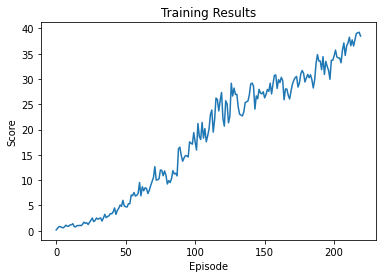

In [8]:
plt.plot(rslt.scores)
plt.title('Training Results')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### Demo
he cell below can be run to demonstrate the behavior of the trained agent. It is necessary to first run all cells except the training cell. One can also review this [video](https://youtu.be/DvaDpi1xjLg) of the trained agent's behavior.

In [6]:
demo_eps = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demo_pol_net = torch.load('submission_pol_net.pt')
demo_pol_net = demo_pol_net.to(device)
demo_pol_net.eval()

env = UnityEnvironment(file_name=env_location)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
for episode in range(demo_eps):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    dones = [False]*def_hyp.num_agnt
    
    while dones.count(True) < def_hyp.num_agnt:
            
            actions = demo_pol_net(torch.tensor(states,device=device)).cpu().detach()        
            env_info = env.step(actions.numpy())[brain_name]
            next_states = env_info.vector_observations
            env_dones = env_info.local_done
            
            for i in range(def_hyp.num_agnt):
                
                if dones[i] == False:
                    
                    dones[i] = env_dones[i]
            
            states = next_states

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Discussion
Added noise was not critical to solve this environment

### Ideas for Future Work

+ Distributional version of DDPG may be faster
+ Train more than one policy network at a time, apply genetic algorithm techniques

## References
[1] Lillicrap et. al., Continuous control with deep reinforcement learning, [arXiv:1509.02971](https://arxiv.org/abs/1509.02971) <br>
[2] Schaul et. al., Prioritized Experience Replay, [arXiv:1511.05952](https://arxiv.org/abs/1511.05952)<br>
[3] Fortunato et. al., Noisy Networks for Exploration, [arXiv:1706.10295](https://arxiv.org/abs/1706.10295)<br>
[4] http://www.sefidian.com/2022/09/09/sumtree-data-structure-for-prioritized-experience-replay-per-explained-with-python-code/<br>
